In [1]:
# If you need to install any missing packages, uncomment:
# %pip install talib-binary      # or your platform’s TA-Lib wheel
# %pip install MetaTrader5

import os
import sys
# Ensure `trading_bot/src` is on sys.path so we can import our modules
sys.path.append(os.path.abspath(".."))
os.chdir("..")

import pandas as pd
import talib
import numpy as np

from src.data_fetch import connect_mt5, fetch_symbol_data
from src.features   import (
    add_RSI_EMA, 
    add_ATR, 
    add_candlestick_patterns,
    add_VSA_signals_refined, 
    detect_order_blocks,
    create_sequences
)


In [2]:
# Load your M5 CSV (make sure this file exists under data/)
df = pd.read_csv("data/XAUUSD_M5.csv", parse_dates=["time"])

# 1 Compute RSI and EMAs on M5
df = add_RSI_EMA(df, rsi_period=14, ema_periods=[20, 50])

# 2 Compute ATR (used later for VSA thresholds and SL/TP)
df = add_ATR(df, atr_period=14)

# 3 Build the 3‐class label (Up/Down/Hold) using ATR_14 threshold logic
#    First, compute ATR_14 explicitly
df["ATR_14"] = talib.ATR(df["High"], df["Low"], df["Close"], timeperiod=14)
#    Next‐bar percent change
df["next_pct_change"] = (df["Close"].shift(-1) - df["Close"]) / df["Close"]
#    Threshold = 0.5 × (ATR_14 / Close)
df["threshold"] = 0.5 * (df["ATR_14"] / df["Close"])

# Label function
def label_with_hold(row):
    change = row["next_pct_change"]
    thr    = row["threshold"]
    if abs(change) <= thr:
        return 2   # Hold
    elif change > thr:
        return 1   # Up
    else:
        return 0   # Down

df["Direction3"] = df.apply(label_with_hold, axis=1)

# 4 Candlestick patterns (hammer, engulfing, doji)
df = add_candlestick_patterns(df)

# 5 VSA signals (No Demand, No Supply, Buying Climax, etc.)
df = add_VSA_signals_refined(df)

# 6 Detect raw order‐block candles (OB_type and OB_price)
df = detect_order_blocks(df)

# 7 Convert OB_type/OB_price into numeric features:
#    - OB_bullish = 1 whenever OB_type == "bullish"; else 0
#    - OB_bearish = 1 whenever OB_type == "bearish"; else 0
#    - Distance_to_OB = |Close − OB_price| / Close; if no OB on that bar, set to 1.0
df["OB_bullish"]     = (df["OB_type"] == "bullish").astype(int)
df["OB_bearish"]     = (df["OB_type"] == "bearish").astype(int)
df["Distance_to_OB"] = (df["Close"] - df["OB_price"]).abs() / df["Close"]
df["Distance_to_OB"].fillna(1.0, inplace=True)

# At this point, OB_type/OB_price still exist (with many NaNs), 
# but the 3 derived columns (OB_bullish, OB_bearish, Distance_to_OB) are fully numeric.


C:\Users\mahme\AppData\Local\Temp\ipykernel_80412\941879484.py:47: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Distance_to_OB"].fillna(1.0, inplace=True)


In [3]:
# Load H1 CSV
df_h1 = pd.read_csv("data/XAUUSD_H1.csv", parse_dates=["time"])

# 1) Compute H1 indicators identically to M5
df_h1 = add_RSI_EMA(df_h1,  rsi_period=14, ema_periods=[50, 100])
df_h1 = add_ATR(df_h1,     atr_period=14)

# 2) Keep only the H1 columns we need
df_h1 = df_h1[["time", "RSI", "EMA_50", "ATR"]].rename(columns={
    "RSI":    "H1_RSI",
    "EMA_50": "H1_EMA_50",
    "ATR":    "H1_ATR"
})

# 3) Sort both DataFrames by time
df   = df.sort_values("time").reset_index(drop=True)
df_h1 = df_h1.sort_values("time").reset_index(drop=True)

# 4) Merge via merge_asof: for each M5 time T, pick the most recent H1 row with time ≤ T
df = pd.merge_asof(
    left=df,
    right=df_h1,
    left_on="time",
    right_on="time",
    direction="backward"
)

# At this point, df["H1_RSI"], df["H1_EMA_50"], df["H1_ATR"] are filled for every M5 row 
# (except perhaps the very first few if the H1 series begins after the first M5 timestamp).


In [4]:
# 1) Check for any NaNs in critical columns
print("▶ NaNs per column BEFORE dropna:")
print(df.isna().sum())

# 2) Focus on core features (not OB_type or OB_price themselves):
#    We want NaNs only in the very first rows where RSI/EMA/ATR aren’t available yet.
essential_cols = [
    "RSI", "EMA_20", "EMA_50", "ATR",
    "ATR_14", "next_pct_change", "threshold", "Direction3",
    "H1_RSI", "H1_EMA_50", "H1_ATR"
]
print("\n▶ NaNs in essential feature columns:")
print(df[essential_cols].isna().sum())

# 3) Show the first few rows (so you can eyeball all columns)
df.head(5)


▶ NaNs per column BEFORE dropna:
time                       0
Open                       0
High                       0
Low                        0
Close                      0
Volume                     0
RSI                       14
EMA_20                    19
EMA_50                    49
ATR                       14
ATR_14                    14
next_pct_change            1
threshold                 14
Direction3                 0
HAMMER                     0
ENGULFING                  0
DOJI                       0
vsa_signal                 0
VSA_No_Demand              0
VSA_No_Supply              0
VSA_Buying_Climax          0
VSA_Selling_Climax         0
VSA_Stopping_Volume        0
OB_type                20000
OB_price               20000
OB_bullish                 0
OB_bearish                 0
Distance_to_OB             0
H1_RSI                     0
H1_EMA_50                  0
H1_ATR                     0
dtype: int64

▶ NaNs in essential feature columns:
RSI              

,time,Open,High,Low,Close,Volume,RSI,EMA_20,EMA_50,ATR,...,VSA_Selling_Climax,VSA_Stopping_Volume,OB_type,OB_price,OB_bullish,OB_bearish,Distance_to_OB,H1_RSI,H1_EMA_50,H1_ATR
0,2025-02-21 08:10:00,2928.23,2929.92,2927.83,2928.79,600,NaN,NaN,NaN,NaN,...,0,0,NaN,NaN,0,0,1.0,42.792434,2934.764935,8.449047
1,2025-02-21 08:15:00,2928.81,2929.48,2926.42,2927.93,745,NaN,NaN,NaN,NaN,...,0,0,NaN,NaN,0,0,1.0,42.792434,2934.764935,8.449047
2,2025-02-21 08:20:00,2928.01,2928.59,2927.33,2927.89,660,NaN,NaN,NaN,NaN,...,0,0,NaN,NaN,0,0,1.0,42.792434,2934.764935,8.449047
3,2025-02-21 08:25:00,2927.81,2928.86,2927.25,2928.77,700,NaN,NaN,NaN,NaN,...,0,0,NaN,NaN,0,0,1.0,42.792434,2934.764935,8.449047
4,2025-02-21 08:30:00,2928.75,2931.38,2928.58,2930.80,745,NaN,NaN,NaN,NaN,...,0,0,NaN,NaN,0,0,1.0,42.792434,2934.764935,8.449047


In [5]:
# Drop only the rows that truly lack a numeric feature (first ~50 rows):
df.dropna(subset=essential_cols, inplace=True)
df.reset_index(drop=True, inplace=True)
print("▶ Rows remaining AFTER dropna:", len(df))

# Inspect the 3‐class distribution
dist3 = df["Direction3"].value_counts(normalize=True) * 100
print("\n▶ 3‐class distribution (%):")
print(dist3)

# Chronological 80/20 train/validation split
train_size = int(len(df) * 0.8)
df_train   = df.iloc[:train_size].copy()
df_val     = df.iloc[train_size:].copy()
print(f"\n▶ df_train rows: {len(df_train)}, df_val rows: {len(df_val)}")

# If df_train is still too small relative to your lookback, either fetch more data 
# or reduce lookback. We'll check that next.


▶ Rows remaining AFTER dropna: 19950

▶ 3‐class distribution (%):
Direction3
2    60.461153
1    20.431078
0    19.107769
Name: proportion, dtype: float64

▶ df_train rows: 15960, df_val rows: 3990


In [6]:
# Define the exact feature columns for modeling (all numeric)
feature_cols = [
    "Close", "RSI",       "EMA_20", "EMA_50", "ATR",
    "H1_RSI", "H1_EMA_50","H1_ATR",
    "VSA_No_Demand", "VSA_No_Supply", "VSA_Buying_Climax",
    "VSA_Selling_Climax", "VSA_Stopping_Volume",
    "OB_bullish", "OB_bearish", "Distance_to_OB"
]
label_col = "Direction3"
lookback  = 60   # if df_train has ≥ 62 rows, this will produce at least one sequence

# Quick check that all feature columns exist:
missing = [c for c in feature_cols if c not in df_train.columns]
print("▶ Missing feature columns (should be []):", missing)

# Build sequences for train & val
X_train, y_train, scaler = create_sequences(df_train, feature_cols, label_col, lookback)
X_val,   y_val,   _      = create_sequences(df_val,   feature_cols, label_col, lookback)

print("\n▶ X_train shape:", X_train.shape, "y_train shape:", y_train.shape)
print("▶ X_val   shape:", X_val.shape,   "y_val   shape:", y_val.shape)


▶ Missing feature columns (should be []): []

▶ X_train shape: (15899, 60, 16) y_train shape: (15899,)
▶ X_val   shape: (3929, 60, 16) y_val   shape: (3929,)


In [7]:
# ----- New Model Cell -----
# 1) Import our build function
from src.model_lstm import build_3class_lstm_model

# 2) Define input_shape based on X_train
#    X_train.shape == (num_samples, lookback, num_features)
lookback     = X_train.shape[1]
num_features = X_train.shape[2]
input_shape  = (lookback, num_features)

# 3) Build and compile
model = build_3class_lstm_model(input_shape)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 128)        │        74,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 60, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 126,723 (495.01 KB)

 Trainable params: 126,275 (493.26 KB)

 Non-trainable params: 448 (1.75 KB)

In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True),
    ModelCheckpoint("../models/XAUUSD_M5_lstm_best.h5", monitor="val_accuracy", save_best_only=True)
]

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.3480 - loss: 1.4576

249/249 ━━━━━━━━━━━━━━━━━━━━ 29s 98ms/step - accuracy: 0.3480 - loss: 1.4574 - val_accuracy: 0.4060 - val_loss: 1.0543
Epoch 2/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.3666 - loss: 1.3044

249/249 ━━━━━━━━━━━━━━━━━━━━ 23s 92ms/step - accuracy: 0.3666 - loss: 1.3043 - val_accuracy: 0.4365 - val_loss: 1.0683
Epoch 3/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.3713 - loss: 1.2681

249/249 ━━━━━━━━━━━━━━━━━━━━ 23s 93ms/step - accuracy: 0.3713 - loss: 1.2681 - val_accuracy: 0.4543 - val_loss: 1.0588
Epoch 4/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.4009 - loss: 1.2042

249/249 ━━━━━━━━━━━━━━━━━━━━ 24s 95ms/step - accuracy: 0.4009 - loss: 1.2041 - val_accuracy: 0.5398 - val_loss: 1.0117
Epoch 5/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 23s 92ms/step - accuracy: 0.4131 - loss: 1.1828 - val_accuracy: 0.4589 - val_loss: 1.0515
Epoch 6/50
248/249 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.4457 - loss: 1.1256

249/249 ━━━━━━━━━━━━━━━━━━━━ 22s 87ms/step - accuracy: 0.4457 - loss: 1.1256 - val_accuracy: 0.5498 - val_loss: 0.9975
Epoch 7/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.4474 - loss: 1.1233

249/249 ━━━━━━━━━━━━━━━━━━━━ 22s 88ms/step - accuracy: 0.4474 - loss: 1.1232 - val_accuracy: 0.5918 - val_loss: 0.9747
Epoch 8/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 25s 99ms/step - accuracy: 0.4803 - loss: 1.0847 - val_accuracy: 0.5882 - val_loss: 0.9789
Epoch 9/50
248/249 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.4865 - loss: 1.0729

249/249 ━━━━━━━━━━━━━━━━━━━━ 22s 87ms/step - accuracy: 0.4865 - loss: 1.0729 - val_accuracy: 0.5999 - val_loss: 0.9583
Epoch 10/50
248/249 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.4960 - loss: 1.0684

249/249 ━━━━━━━━━━━━━━━━━━━━ 22s 87ms/step - accuracy: 0.4960 - loss: 1.0684 - val_accuracy: 0.6075 - val_loss: 0.9514
Epoch 11/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.5027 - loss: 1.0625

249/249 ━━━━━━━━━━━━━━━━━━━━ 42s 89ms/step - accuracy: 0.5027 - loss: 1.0625 - val_accuracy: 0.6093 - val_loss: 0.9499
Epoch 12/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 21s 86ms/step - accuracy: 0.5059 - loss: 1.0623 - val_accuracy: 0.6075 - val_loss: 0.9484
Epoch 13/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 22s 86ms/step - accuracy: 0.5296 - loss: 1.0348 - val_accuracy: 0.6088 - val_loss: 0.9514
Epoch 14/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 23s 94ms/step - accuracy: 0.5325 - loss: 1.0385 - val_accuracy: 0.6088 - val_loss: 0.9447
Epoch 15/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 33s 132ms/step - accuracy: 0.5371 - loss: 1.0368 - val_accuracy: 0.6088 - val_loss: 0.9460
Epoch 16/50
249/249 ━━━━━━━━━━━━━━━━━━━━ 25s 102ms/step - accuracy: 0.5517 - loss: 1.0169 - val_accuracy: 0.6088 - val_loss: 0.9460


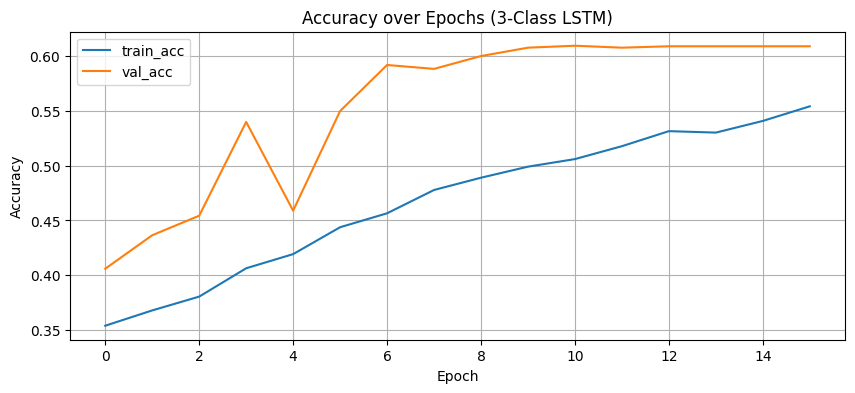

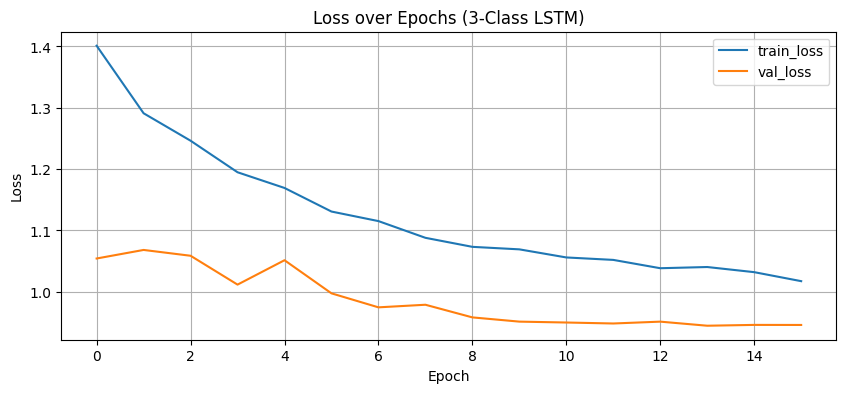

In [9]:
import matplotlib.pyplot as plt

# Accuracy
plt.figure(figsize=(10,4))
plt.plot(history.history["accuracy"], label="train_acc")
plt.plot(history.history["val_accuracy"], label="val_acc")
plt.title("Accuracy over Epochs (3-Class LSTM)")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)
plt.show()

# Loss
plt.figure(figsize=(10,4))
plt.plot(history.history["loss"], label="train_loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.title("Loss over Epochs (3-Class LSTM)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()
